In [1]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir('/home/mohammed/Work/STK_search')
from pathlib import Path#

import pandas as pd
import torch
import numpy as np
from stk_search.utils.config_utils import read_config, save_config
from stk_search.utils import config_utils
import datetime
from stk_search.utils import update_datasets
import importlib
importlib.reload(config_utils)

<module 'stk_search.utils.config_utils' from '/home/mohammed/Work/STK_search/src/stk_search/utils/config_utils.py'>

In [12]:
#Helper function to split the dataset
from stk_search.geom3d import polymer_GNN_architecture_utils

def check_building_block_present(df_total_path_new,config_dir):
    df_total = pd.read_csv(df_total_path_new,low_memory=False)
    config = read_config(config_dir)
    bbs_dict = polymer_GNN_architecture_utils.get_bbs_dict(
        config['pymongo_client'] , config['precursor_database_name']
    )
    bbs_dict
    # check df_total has inchikey in bb_dict
    for i in range(6):
        df_total = df_total[df_total[f'InChIKey_{i}'].isin(bbs_dict.keys())]
    df_total.to_csv(df_total_path_new, index=False)
    return df_total

def do_random_split(config,hide_best_molecules=True):
    df_path = Path(
            config["df_total"]
        )
    if os.path.isfile(df_path):
        df = pd.read_csv(df_path,low_memory=False)
    else:
        print("No dataframe found, will resort in a random split from the data in the database")
    def topk_split(topkmol, df,num_molecules_dataset=5000,target_name='target',hide_best_molecules=hide_best_molecules):
        min_target_out_of_database = -np.sort(-df[target_name].values)[topkmol]
        df_test = df[df[target_name]>=min_target_out_of_database]
        if hide_best_molecules:
            df_train = df[df[target_name]<min_target_out_of_database]
        else:
            df_train = df.copy()
            print(df_train.shape[0])
        # add random element from df to the test set
        #df_test_random = df.sample(n=1000, random_state=1)
        #df_test = pd.concat([df_test, df_test_random])
        df_test.reset_index(drop=True, inplace=True)
        list_col = [f'InChIKey_{x}' for x in range(6)]
        list_col.append(target_name)
        list_col.append('InChIKey')
        df_train = df_train[list_col]
        df_train = df_train[~df_train['InChIKey'].isin(df_test['InChIKey'])]
        if num_molecules_dataset>df_train.shape[0]:
            print("Warning: the number of molecules in the dataset is smaller than the number of molecules requested")
            num_molecules_dataset = df_train.shape[0]
        df_train = df_train.sample(num_molecules_dataset)
        df_val = df_train.sample(frac=0.1, random_state=1)
        df_train = df_train[~df_train['InChIKey'].isin(df_val['InChIKey'])]
        df_train.reset_index(drop=True, inplace=True)
        df_val.reset_index(drop=True, inplace=True)
        return df_train, df_val, df_test
    topKmol = int(df.shape[0]*0.01)
    df_train, df_val, df_test = topk_split(topKmol, df,config["num_molecules"],config["target_name"],hide_best_molecules=hide_best_molecules)
    config_dir= config["running_dir"]
    df_train.to_csv(config_dir + "df_train.csv", index=False)
    df_val.to_csv(config_dir + "df_val.csv", index=False)
    df_test.to_csv(config_dir + "df_test.csv", index=False)
    for key in ['df_train','df_val','df_test']:
        check_building_block_present(config_dir + key + ".csv",config_dir)
    return df_train, df_val, df_test



In [13]:
# load the database to learn from
df_total_path_new = 'data/Full_dataset/New_target07072024.csv'
#df_total_path_new = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_total = pd.read_csv(df_total_path_new,low_memory=False)
print(df_total.shape[0])
df_total

74508


,Unnamed: 0,InChIKey,BB,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au),ES1,fosc1,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,target
0,0,AAAIKLIUXQWZQC-SBRRWJCQSA-N,"[{'InChIKey': 'SWJPEBQEEAHIGZ-UHFFFAOYSA-N'}, ...",3.7458,0.020987,7.3767,-251.681432,3.311,0.1454,SWJPEBQEEAHIGZ-UHFFFAOYSA-N,WLJMWJRNANCLLB-UQCOIBPSSA-N,QKOAHMWMROSOCB-UHFFFAOYSA-N,NACLVJFIPGLGGF-UHFFFAOYSA-N,WLJMWJRNANCLLB-UQCOIBPSSA-N,KESGZSFJWVCXKF-UHFFFAOYSA-N,-3.025136
1,1,AAALPPGKJQYWNO-NOPDUFPGSA-N,"[{'InChIKey': 'AZYPAMWLUNRZKI-UHFFFAOYSA-N'}, ...",3.2475,0.014649,6.5768,-219.209051,2.674,0.1693,AZYPAMWLUNRZKI-UHFFFAOYSA-N,BMAXCOSCNAUKQK-WCIBSUBMSA-N,AVQCSVOAVAVAMJ-UHFFFAOYSA-N,WNSNPGHNIJOOPM-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,CGQMQIAGYJZKNI-UHFFFAOYSA-N,-2.174143
2,2,AAAVCXUUFSMNCC-UBCNBMAWSA-N,"[{'InChIKey': 'KYORXLIHDAZXPK-UHFFFAOYSA-N'}, ...",3.6878,0.054748,6.5672,-238.356300,2.554,0.1542,KYORXLIHDAZXPK-UHFFFAOYSA-N,VHGPRJAKJSOPER-CLTKARDFSA-N,SXRSYJAHJIIXFM-UHFFFAOYSA-N,UNOXOWXWZXWVFR-WMZJFQQLSA-N,BZXFPIODHNEVBA-VHSXEESVSA-N,NDROOZZFHGBQAJ-UHFFFAOYSA-N,-2.325116
3,3,AABBVYXCVOYVDW-UHFFFAOYSA-N,"[{'InChIKey': 'ZQUFQULVODWNAL-UHFFFAOYSA-N'}, ...",2.2176,0.132006,5.8241,-200.622918,2.758,5.4769,ZQUFQULVODWNAL-UHFFFAOYSA-N,KEPNBEPTGHROGD-UHFFFAOYSA-N,APDAUBNBDJUQGW-UHFFFAOYSA-N,VEGYYSITGMCNND-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,MNIZKSJELYBCRS-UHFFFAOYSA-N,0.172435
4,4,AABGSZOIKXWDFV-ZOZSLMIISA-N,"[{'InChIKey': 'YHOAKOTYECSOIZ-UHFFFAOYSA-N'}, ...",3.4602,0.105403,6.5770,-248.482482,2.926,1.5505,YHOAKOTYECSOIZ-UHFFFAOYSA-N,UVCFYBOLMFIWGF-FPYGCLRLSA-N,HFUBKQHDPJZQIW-UHFFFAOYSA-N,LPRVANXWMPVCRC-BAQGIRSFSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MNIZKSJELYBCRS-UHFFFAOYSA-N,-0.960528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74503,74503,ZZYSUNFOVLRAFN-UHFFFAOYSA-N,"[{'InChIKey': 'WBRIMLGNHKTADJ-UHFFFAOYSA-N'}, ...",2.0255,0.016826,6.0319,-188.068064,3.389,2.7829,WBRIMLGNHKTADJ-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,WBRIMLGNHKTADJ-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,-0.476402
74504,74504,ZZZACLCMBMACSP-UHFFFAOYSA-N,"[{'InChIKey': 'WVGHJMFKJADIAM-UHFFFAOYSA-N'}, ...",2.6251,0.048152,6.2825,-194.795068,2.742,0.7143,WVGHJMFKJADIAM-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,-1.186619
74505,74505,ZZZITEJEPMDYEK-UHFFFAOYSA-N,"[{'InChIKey': 'AFVRECUINNLWPU-UHFFFAOYSA-N'}, ...",2.6539,0.005467,5.9820,-253.211741,3.539,0.2647,AFVRECUINNLWPU-UHFFFAOYSA-N,ZQUFQULVODWNAL-UHFFFAOYSA-N,SOESJFVMGGQDFQ-UHFFFAOYSA-N,SOESJFVMGGQDFQ-UHFFFAOYSA-N,ZQUFQULVODWNAL-UHFFFAOYSA-N,AFVRECUINNLWPU-UHFFFAOYSA-N,-1.598246
74506,74506,ZZZMJQCVJSAPPT-UHFFFAOYSA-N,"[{'InChIKey': 'WBRIMLGNHKTADJ-UHFFFAOYSA-N'}, ...",2.2173,0.033492,5.7670,-211.437641,2.769,4.3747,WBRIMLGNHKTADJ-UHFFFAOYSA-N,SOESJFVMGGQDFQ-UHFFFAOYSA-N,SXRSYJAHJIIXFM-UHFFFAOYSA-N,SIGAQDSGJJFBIC-UHFFFAOYSA-N,KEPNBEPTGHROGD-UHFFFAOYSA-N,VEGYYSITGMCNND-UHFFFAOYSA-N,0.142948


In [14]:

importlib.reload(update_datasets)
importlib.reload(config_utils)
config_dir_list = []
df_total_path = df_total_path_new
pymongo_client = "mongodb://localhost:27017/"
for num_molecules in [5000,10000,20000]:
    config = config_utils.generate_config(
        num_molecules=num_molecules, df_path=df_total_path, max_epochs=200,
        target_name = 'target', 
        running_dir = f"data/representation_learning/",
    )
    config['pymongo_client'] = pymongo_client
    config['precursor_database_name'] = 'stk_mohammed_constructed'
    config['database_name'] = 'stk_mohammed_constructed'
    config['df_precursor'] = "data/input/Prescursor_data/df_properties_24072024.pkl"
    config["ephemeral_path"] = "data/representation_learning/ephemeral/Random_split/"
    config['max_epochs'] = 10
    config_dir= config["running_dir"]
    save_config(config,config_dir)
    if config["split_type"] == "rand":
        df_train, df_val, df_test = do_random_split(config,hide_best_molecules=True)
    
    config_dir_list.append(config_dir)

config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol10000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol10000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol10000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol10000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol20000/
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol2

In [6]:
#test script
config_dir =  "data/representation_learning/configs/Random_split_5000_molecules//6-frag/target/240724//SchNet/splitrand-nummol5000/"
%run src/dev_scripts/run_representation_learning_polymer.py --config_dir {config_dir}


config loaded from data/representation_learning/configs/Random_split_5000_molecules//6-frag/target/240724//SchNet/splitrand-nummol5000/


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model loaded:  SchNet


wandb: Currently logged in as: mohammed-azzouzi15 (azzouzi_lab). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/mohammed/Work/STK_search/data/representation_learning/configs/Random_split_5000_molecules/6-frag/target/240724/SchNet/splitrand-nummol5000/data/representation_learning/configs/Random_split_5000_molecules/6-frag/target/240724/SchNet/splitrand-nummol5000 exists and

Apply lr scheduler CosineAnnealingLR


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,███████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
train_loss,██▇▅▅▇▄▃▄▃▄▃▃▂▃▂▂▂▃▂▅▃▂▃▄▄▃▄▃▃▂▂▂▂▂▂▂▁▁▁
train_loss_repr,█▅▂▃▂▃▂▃▄▁▂▁▂▂▂▁▂▃▁▂▂▂▂▂▂▂▂▃▃▃▂▂▂▂▂▄▂▄▄▄
train_loss_target,██▇▅▅▇▄▃▄▃▄▃▃▂▃▂▂▂▃▂▅▃▂▃▄▄▃▄▃▃▂▂▂▂▂▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▆▆▅▅▅▅▃▃▄▃▃▄▃▃▂▃▃▂▂▃▃▂▂▂▁▃▁▂▂▂▂▂▃▂▂▁▂▂
val_loss_repr,█▅▂▂▃▃▂▂▂▂▄▁▁▃▂▂▂▁▂▁▂▂▂▂▂▂▃▃▂▂▂▃▃▃▃▄▃▄▄▄
val_loss_target,█▆▆▆▅▅▅▅▃▃▄▃▃▄▄▃▂▃▃▂▂▃▃▂▂▂▁▃▁▂▂▂▂▂▃▂▂▁▁▂
epoch,68
lr,0.00037


Total time taken for model training: 365.566148519516 seconds
config loaded from data/representation_learning/configs/Random_split_5000_molecules//6-frag/target/240724//SchNet/splitrand-nummol5000/
data/representation_learning/configs/Random_split_5000_molecules//6-frag/target/240724//SchNet/splitrand-nummol5000/epoch=29-val_loss=0.15-other_metric=0.00.ckpt
data/representation_learning/configs/Random_split_5000_molecules//6-frag/target/240724//SchNet/splitrand-nummol5000/epoch=48-val_loss=0.14-other_metric=0.00.ckpt
Model loaded:  SchNet
Model loaded
Model evaluation done
MAE: 0.52, MSE: 0.46, R2: 0.58
MAE: 0.51, MSE: 0.40, R2: 0.60
MAE: 0.80, MSE: 0.76, R2: -173.28


In [19]:

# run model training including all data
name = "new_representation_different_embedding"
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

script="#!/bin/bash \n"+\
    "#PBS -l walltime=23:59:01 \n"+\
    "#PBS -l select=1:ncpus=4:mem=24gb:ngpus=1:gpu_type=RTX6000 \n"+\
    " \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate Geom3D     \n"
for config_dir in config_dir_list:
    script = script+\
        "cd /rds/general/user/ma11115/home/STK_Search/STK_search/ \n"+\
        f"python  src/dev_scripts/run_representation_learning_polymer.py --config_dir {config_dir}\n"
#print(script) 
with open(f'HPC_bash_script/{name}.sh', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  
sh_path = f'HPC_bash_script/{name}.sh'
!qsub -e ./cache -o ./cache {sh_path}

9432175.pbs


## test representation


In [9]:
from stk_search.geom3d import pl_model
import torch.nn.functional as Functional
from stk_search.geom3d import train_models
from stk_search.Representation import  Representation_poly_3d

import importlib
importlib.reload(Representation_poly_3d)


def load_representation_model(config_dir):
    config = read_config(config_dir)
    chkpt_path = config["model_embedding_chkpt"]
    checkpoint = torch.load(chkpt_path, map_location=config["device"])
    model, graph_pred_linear = pl_model.model_setup(config)
    print("Model loaded: ", config["model_name"])
    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = pl_model.Pymodel_new(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    #pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    pymodel.to(config["device"])
    representation = Representation_poly_3d.Representation_poly_3d(pymodel,device='cpu',
                                                                   mongo_client=config['pymongo_client'],
                                                                   database=config['database_name'],)
    return representation, pymodel

In [ ]:
config_dir

In [10]:
# load the representation and the model 

from stk_search.Representation import  Representation_poly_3d
import importlib
importlib.reload(Representation_poly_3d)
#config_dir = "/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240430/SchNet/splitrand-nummol68864/Emb_dim_12"
config_dir = "data/representation_learning/6-frag/target/240724//SchNet/splitrand-nummol5000/"
config, min_val_loss = train_models.get_best_embedding_model(config_dir)

Representation, pymodel = load_representation_model(config_dir)
#representation.device = 'cpu'

config loaded from data/representation_learning/6-frag/target/240724//SchNet/splitrand-nummol5000/
data/representation_learning/6-frag/target/240724//SchNet/splitrand-nummol5000/epoch=48-val_loss=0.14-other_metric=0.00.ckpt
config loaded from data/representation_learning/6-frag/target/240724//SchNet/splitrand-nummol5000/
Model loaded:  SchNet


ServerSelectionTimeoutError: 129.31.66.201:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 66a3a3b806b6a20e11cba9b2, topology_type: Unknown, servers: [<ServerDescription ('129.31.66.201', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('129.31.66.201:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [ ]:
df_name = 'train'
config = read_config(config_dir)
df = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_train = df.sample(1000)
df_elements_train = df_train[[f'InChIKey_{x}' for x in range(6)]]
df_name = 'test'
df_test = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_test = df_test.sample(1000)
df_elements_test = df_test[[f'InChIKey_{x}' for x in range(6)]]
df_name = 'val'
df_val = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_val = df_val.sample(1000)
df_elements_val = df_val[[f'InChIKey_{x}' for x in range(6)]]

config loaded from /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240430/SchNet/splitrand-nummol68864/Emb_dim_12


Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

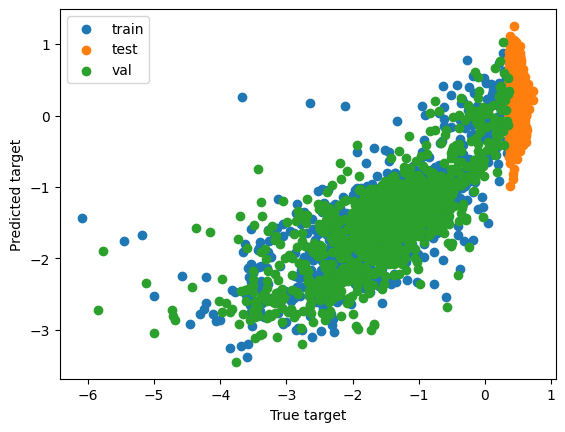

Training scores


In [ ]:
def get_prediction_results(df_element):
    with torch.no_grad():
        X_rpr = Representation.generate_repr(df_element)
        Y_pred = pymodel.graph_pred_linear(X_rpr).flatten(0).detach()
    return Y_pred

Y_pred_train = get_prediction_results(df_elements_train)
Y_pred_test = get_prediction_results(df_elements_test)
Y_pred_val = get_prediction_results(df_elements_val)

Y_train = df_train['target'].values
Y_test = df_test['target'].values
Y_val = df_val['target'].values

import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
ax.scatter(Y_train,Y_pred_train,label='train')  
ax.scatter(Y_test,Y_pred_test,label='test')
ax.scatter(Y_val,Y_pred_val,label='val')
ax.set_xlabel("True target")
ax.set_ylabel("Predicted target")
ax.legend()
plt.show()
# print training scores
print("Training scores")



In [ ]:
def get_scores(Y_pred,Y_true):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(Y_true,Y_pred)
    mae = mean_absolute_error(Y_true,Y_pred)
    R2 = r2_score(Y_true,Y_pred)

    return mse,mae, R2
mse_train,mae_train, R2_train = get_scores(Y_pred_train,Y_train)
mse_test,mae_test, R2_test = get_scores(Y_pred_test,Y_test)
mse_val,mae_val, R2_val = get_scores(Y_pred_val,Y_val)
print(f"MSE train: {mse_train}, MAE train: {mae_train}, R2 train: {R2_train}")
print(f"MSE test: {mse_test}, MAE test: {mae_test}, R2 test: {R2_test}")
print(f"MSE val: {mse_val}, MAE val: {mae_val}, R2 val: {R2_val}")

MSE train: 0.41741392266360355, MAE train: 0.4676972189322651, R2 train: 0.5379552830780119
MSE test: 0.15488473709521342, MAE test: 0.32240911147765006, R2 test: -31.378035371730427
MSE val: 0.4015274467785838, MAE val: 0.4712140871078302, R2 val: 0.5621482989066203
